# Binary-Class Model for Acoustic Extinguisher Fire Using TensorFlow Decision Forests
### David Lowe
### March 29, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Acoustic Extinguisher Fire dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Fire is a disaster that can have many different causes, and traditional fire extinguishing methods can be harmful to people. In this study, the research team tested a sound wave flame-extinguishing system to extinguish the flames at an early fire stage. The researchers conducted 17,442 extinguishing experiments using different flame sizes, frequencies, and distance ranges in their study. The goal is to create an environmentally friendly system with innovative extinguishing methods.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved an accuracy benchmark of 99.26% on the training dataset. When we applied the finalized model to the test dataset, the model achieved an accuracy score of 97.82%.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be suitable for modeling this dataset.

Dataset Used: Acoustic Extinguisher Fire Dataset

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://www.muratkoklu.com/datasets/

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# Define the directory locations and file names
TRAIN_DATASET = 'heart_2020_cleaned.csv'
# TEST_DATASET = ''

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

2022-03-21 00:56:13.795871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


TensorFlow version: 2.8.0
Found TensorFlow Decision Forests v0.2.4


2022-03-21 00:56:13.857886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 00:56:13.858286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 00:56:13.859675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 00:56:13.860460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-acoustic-extinguisher-fire/Acoustic_Extinguisher_Fire_Dataset.arff'
colNames = ['SIZE','FUEL','DISTANCE','DESIBEL','AIRFLOW','FREQUENCY','CLASS']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=60)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   SIZE      FUEL  DISTANCE  DESIBEL  AIRFLOW  FREQUENCY  CLASS
0     1  gasoline        10       96      0.0         75      0
1     1  gasoline        10       96      0.0         72      1
2     1  gasoline        10       96      2.6         70      1
3     1  gasoline        10       96      3.2         68      1
4     1  gasoline        10      109      4.5         67      1


In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   CLASS      17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [10]:
print(df_dataset_import.describe())

               SIZE      DISTANCE       DESIBEL       AIRFLOW     FREQUENCY  \
count  17442.000000  17442.000000  17442.000000  17442.000000  17442.000000   
mean       3.411765    100.000000     96.379142      6.975634     31.611111   
std        1.750977     54.773826      8.164096      4.736169     20.939149   
min        1.000000     10.000000     72.000000      0.000000      1.000000   
25%        2.000000     50.000000     90.000000      3.200000     14.000000   
50%        3.000000    100.000000     95.000000      5.800000     27.500000   
75%        5.000000    150.000000    104.000000     11.200000     47.000000   
max        7.000000    190.000000    113.000000     17.000000     75.000000   

              CLASS  
count  17442.000000  
mean       0.497821  
std        0.500010  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  


In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

SIZE         0
FUEL         0
DISTANCE     0
DESIBEL      0
AIRFLOW      0
FREQUENCY    0
CLASS        0
dtype: int64
Total number of NaN in the dataframe:  0


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('CLASS').size())

CLASS
0    8759
1    8683
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'CLASS': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   SIZE      FUEL  DISTANCE  DESIBEL  AIRFLOW  FREQUENCY  target
0     1  gasoline        10       96      0.0         75       0
1     1  gasoline        10       96      0.0         72       1
2     1  gasoline        10       96      2.6         70       1
3     1  gasoline        10       96      3.2         68       1
4     1  gasoline        10      109      4.5         67       1


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   target     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [15]:
print(df_dataset_import.describe())

               SIZE      DISTANCE       DESIBEL       AIRFLOW     FREQUENCY  \
count  17442.000000  17442.000000  17442.000000  17442.000000  17442.000000   
mean       3.411765    100.000000     96.379142      6.975634     31.611111   
std        1.750977     54.773826      8.164096      4.736169     20.939149   
min        1.000000     10.000000     72.000000      0.000000      1.000000   
25%        2.000000     50.000000     90.000000      3.200000     14.000000   
50%        3.000000    100.000000     95.000000      5.800000     27.500000   
75%        5.000000    150.000000    104.000000     11.200000     47.000000   
max        7.000000    190.000000    113.000000     17.000000     75.000000   

             target  
count  17442.000000  
mean       0.497821  
std        0.500010  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  


In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

SIZE         0
FUEL         0
DISTANCE     0
DESIBEL      0
AIRFLOW      0
FREQUENCY    0
target       0
dtype: int64
Total number of NaN in the dataframe:  0


In [17]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    8759
1    8683
dtype: int64


### 1.e) Splitting Data into Sets

In [18]:
# Split the data further into training and test datasets
df_dataset_train, df_dataset_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                     stratify=df_dataset_import['target'])
print("df_dataset_train.shape: {} df_dataset_test.shape: {}".format(df_dataset_train.shape, df_dataset_test.shape))

df_dataset_train.shape: (14825, 7) df_dataset_test.shape: (2617, 7)


In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_train['target']
df_features_train = df_dataset_train.drop(['target'], axis=1)

print("df_dataset_train.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_train.shape, df_features_train.shape, df_target_train.shape))

df_dataset_train.shape: (14825, 7) df_features_train.shape: (14825, 6) df_target_train.shape: (14825,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

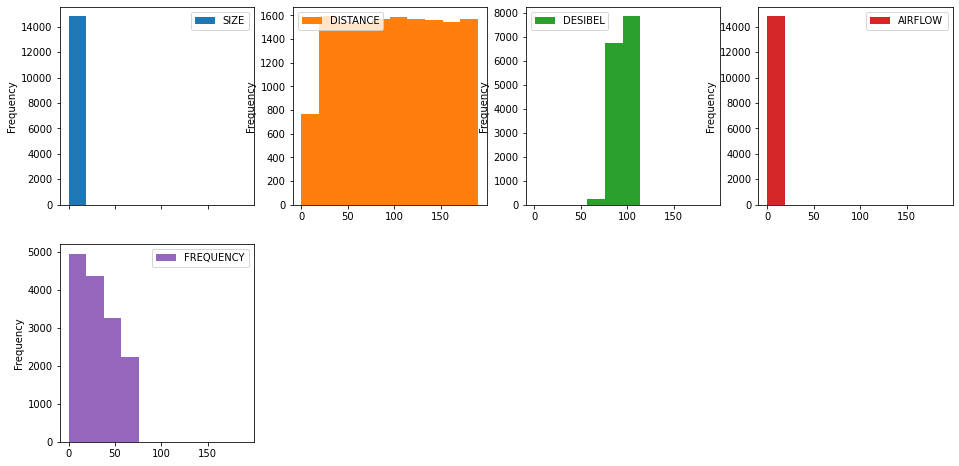

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

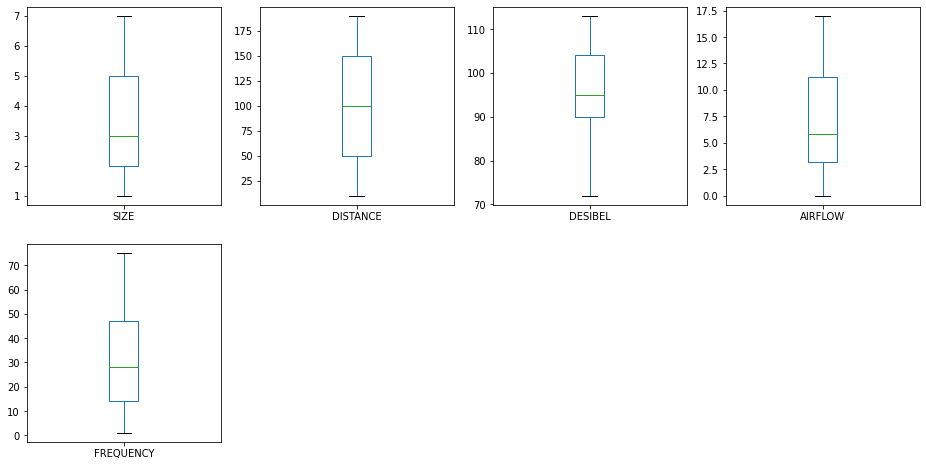

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

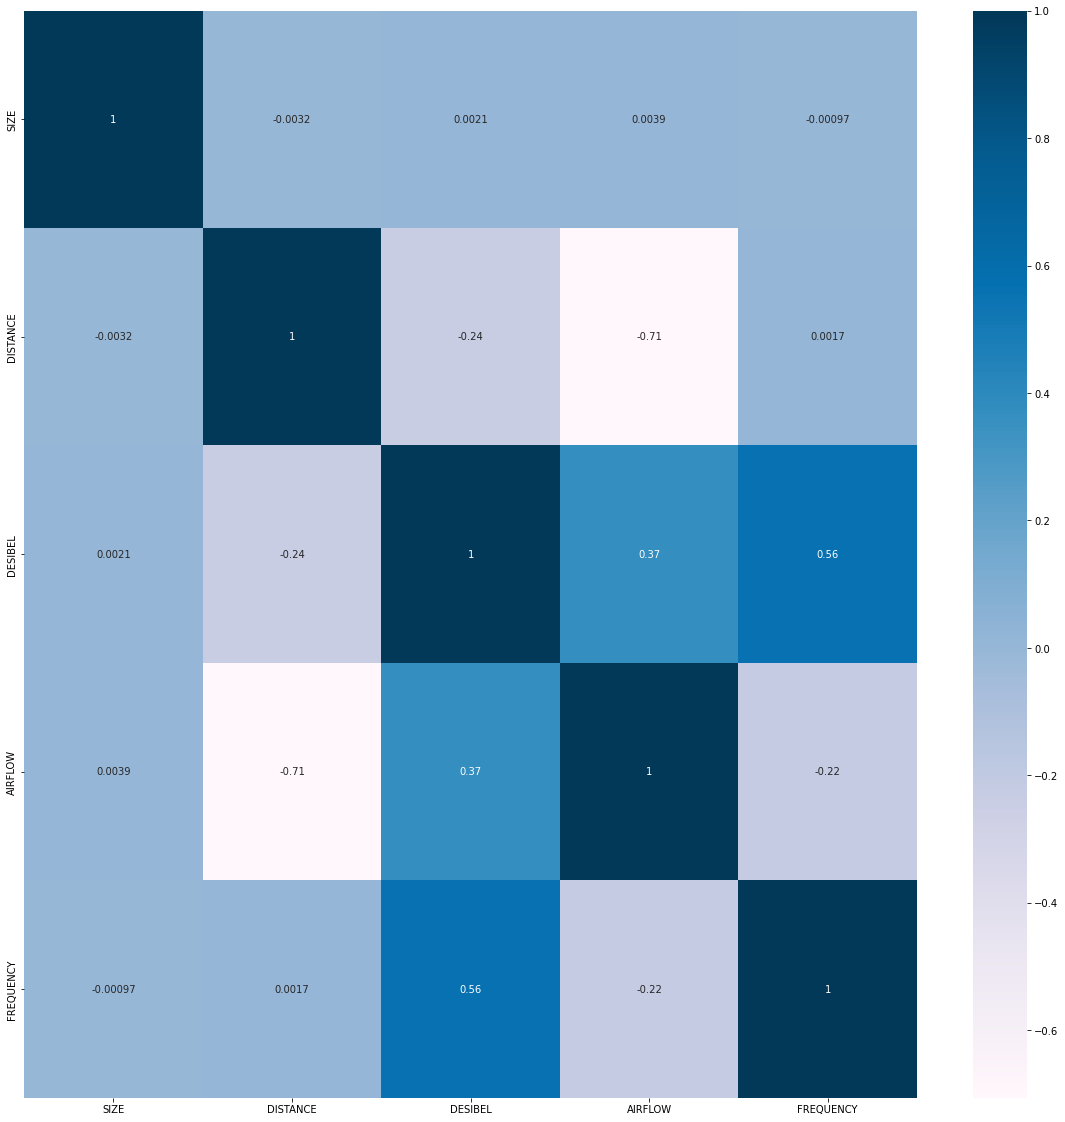

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [28]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)

### 3.b) Train and Evaluate the Random Forest Model

In [29]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpyiapq_q2 as temporary training directory
Starting reading the dataset
11/15 [=====================>........] - ETA: 0s 
Dataset read in 0:00:03.251559
Training model
Model trained in 0:00:01.135207
Compiling model


[INFO kernel.cc:1153] Loading model from path


15/15 [==============================] - 5s 128ms/step


[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model training time: 0:00:06.491471 



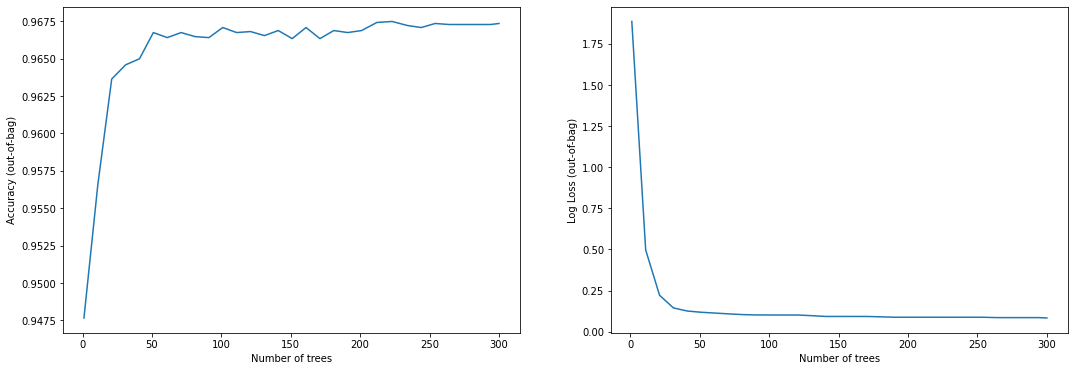

In [30]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [31]:
RF_eval = RF_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

15/15 [==============================] - 1s 28ms/step - loss: 0.0000e+00 - accuracy: 0.9890 - auc: 0.9995

loss: 0.0000
accuracy: 0.9890
auc: 0.9995


### 3.c) Train and Evaluate the Decision Trees Model

In [32]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpifytbju2 as temporary training directory
Starting reading the dataset
10/15 [===================>..........] - ETA: 0s
Dataset read in 0:00:00.175964
Training model
Model trained in 0:00:00.021079
Compiling model
15/15 [==============================] - 0s 7ms/step
Model training time: 0:00:00.325388 



[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


In [33]:
CART_eval = CART_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

15/15 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - auc: 0.9947

loss: 0.0000
accuracy: 0.9512
auc: 0.9947


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [34]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpifefh09j as temporary training directory
Starting reading the dataset
11/15 [=====================>........] - ETA: 0s
Dataset read in 0:00:00.178184
Training model
Model trained in 0:00:04.122599
Compiling model
15/15 [==============================] - 4s 303ms/step
Model training time: 0:00:04.476859 



[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


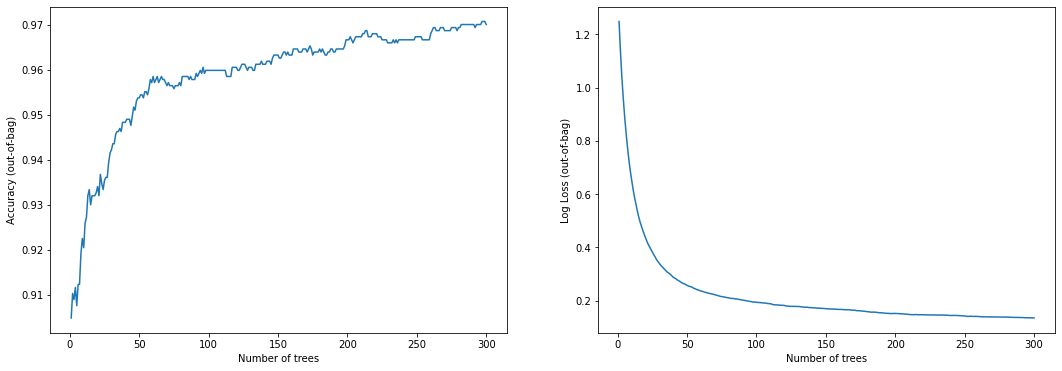

In [35]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [36]:
GBT_eval = GBT_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

15/15 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.9926 - auc: 0.9968

loss: 0.0000
accuracy: 0.9926
auc: 0.9968


In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Not applicable for this iteration of modeling

In [40]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [41]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [42]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpmmebmdxv as temporary training directory
Starting reading the dataset
12/15 [=======================>......] - ETA: 0s
Dataset read in 0:00:00.178780
Training model
Model trained in 0:00:04.088960
Compiling model
15/15 [==============================] - 4s 300ms/step
Model training time: 0:00:04.470013 



[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine


In [43]:
Final_model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	AIRFLOW
	DESIBEL
	DISTANCE
	FREQUENCY
	FUEL
	SIZE

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.   "__LABEL"  4.973915 ################
    2.   "DESIBEL"  4.626357 ##############
    3.      "FUEL"  3.453395 ########
    4.      "SIZE"  2.802992 ####
    5.   "AIRFLOW"  2.501675 ###
    6. "FREQUENCY"  2.467306 ##
    7.  "DISTANCE"  1.927991 

Variable Importance: NUM_AS_ROOT:
    1.  "DISTANCE" 97.000000 ################
    2.   "AIRFLOW" 74.000000 ############
    3. "FREQUENCY" 61.000000 ##########
    4.      "SIZE" 61.000000 ##########
    5.      "FUEL"  6.000000 
    6.   "DESIBEL"  1

### 5.b) Load Test Dataset and Make Predictions

In [44]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_test, label='target', task = tfdf.keras.Task.CLASSIFICATION)

In [45]:
Final_eval = Final_model.evaluate(tfds_test, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.9782 - auc: 0.9969

loss: 0.0000
accuracy: 0.9782
auc: 0.9969


In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:02:07.223127
